# Importing Libraries
The basic libraries such as numpy, matplotlib, random and collections are imported here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from collections import defaultdict

# Importing Images
The images are read using matplotlib.image.imread and are shown using matplotlib.pyplot.imshow

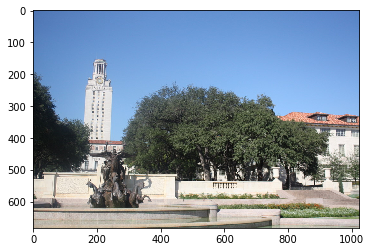

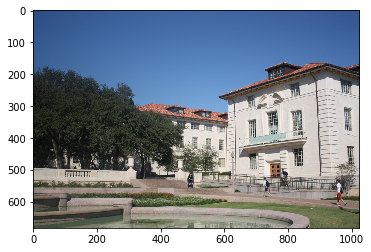

In [2]:
image1 = mpimg.imread("uttower_left.JPG")
image2 = mpimg.imread("uttower_right.JPG")
plt.imshow(image1)
plt.figure()
plt.imshow(image2)
plt.show()

# Calculating the gradient magnitude and direction for each of the images
The images are first converted to grayscale and then the magnitude is found out by taking the gradient for each x and y directions and applying Euclidean norm on them. The direction is found out by taking the tan inverse of vertical gradient divided by horizontal gradient

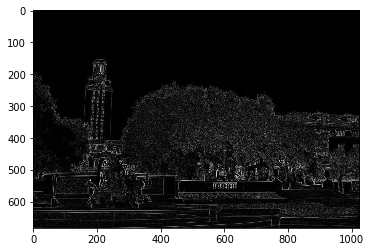

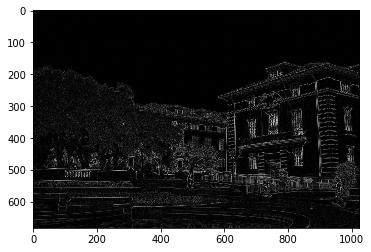

In [3]:
grayimage1 = np.dot(image1[...,:3], [0.299, 0.587, 0.114])
magnitude1 = np.linalg.norm((grayimage1 - np.pad(grayimage1[1:], ((0, 1),(0, 0)), 
                            'edge'), np.pad(grayimage1[:,1:], ((0, 0),(0, 1)), 
                            'edge')-grayimage1), axis=0)
direction1 = np.arctan2((grayimage1 - np.pad(grayimage1[1:], ((0, 1),(0, 0)), 
                        'edge')), (np.pad(grayimage1[:,1:], ((0, 0),(0, 1)), 
                        'edge')-grayimage1))
plt.imshow(magnitude1, cmap="gray")
plt.show()
plt.figure()
grayimage2 = np.dot(image2[...,:3], [0.299, 0.587, 0.114])
magnitude2 = np.linalg.norm((grayimage2 - np.pad(grayimage2[1:], ((0, 1),(0, 0)), 
                            'edge'), np.pad(grayimage2[:,1:], ((0, 0),(0, 1)), 
                            'edge')-grayimage2), axis=0)
direction2 = np.arctan2((grayimage2 - np.pad(grayimage2[1:], ((0, 1),(0, 0)), 
                        'edge')), (np.pad(grayimage2[:,1:], ((0, 0),(0, 1)), 
                        'edge')-grayimage2))
plt.imshow(magnitude2, cmap="gray")
plt.show()

# Defining classes and functions
## Descriptor Class
The class is designed so that for a particular feature a 16x16 window is taken and then it is divided into 16 4x4 windows with each window containing a 8 dimensional histogram in it containing the frequencies of various angles encountered. Also the distance function is defined which takes another descriptor as an argument and returns the Euclidean distance between them.

## Gaussian Filter
The Gaussian Filter is constructed using Gaussian_filter(n, sigma) function which takes window size n and standard deviation sigma as arguments and returns the filter corresponding to it.

## Difference of Gaussian Filter
The Difference of Gaussian filter is returned using differenceOfGaussian(k,n,sigma) function which takes the window size n, standard deviation sigma and the factor k.

## Apply filter
The apply_filter(img, lapl) takes the image and the filter lapl as arguments and returns the output after convoluting the image with the filter after converting it to grayscale.

## Max filter
The max_filter(org_img, img, direction, K, sigma) take the original image, convoluted image, direction of gradients matrix along with K factor and standard deviation sigma and returns the non-max suppressed descriptors sorted as per their coordinates. It also plots the features on the original image.

In [4]:
class descriptor:
    def __init__(self, x, y, image):
        self.x = x
        self.y = y
        intervals = np.arange(-np.pi, np.pi, np.pi/4)
        self.count = np.zeros((16, intervals.shape[0]))
        p = 0
        for l in range(4):
            for m in range(4):   
                for i in (image[l*4:l*4+4, m*4:m*4+4]):
                    for k in i:
                        for j in range(len(intervals)):
                            if(k > intervals[j] and k <= intervals[j]+np.pi/4):
                                self.count[p][j] += 1
                                break
                p += 1
    def distance(self, descript):
        return np.linalg.norm(self.count-descript.count)
def Gaussian_filter(n, sigma):
    gaus_filter = np.array([range(-n//2+1, n//2+1, 1) for _ in range(n)])
    gaus_filter = np.square(gaus_filter) + np.square(gaus_filter.T)
    gaus_filter = (1/(2*np.pi*np.square(sigma)))*np.exp(-
                    gaus_filter/(2*np.square(sigma)))
    return(gaus_filter) 
def differenceOfGaussian(k,n,sigma):
    org_filter=Gaussian_filter(n,sigma)
    scaled_filter=Gaussian_filter(n,k*sigma)
    return scaled_filter-org_filter  
def apply_filter(img, lapl):
    if(len(img.shape) == 3):
        img = np.dot(img[...,:3], [0.299, 0.587, 0.114])
    K = lapl.shape[0]
    img = np.pad(img, (K//2, K//2), 'edge')
    M, N = img.shape
    final_image = np.zeros(img.shape)
    for i in range(M-K):
        for j in range(N-K):
            final_image[i+K//2, j+K//2] = np.multiply(img[i:i+K, j:j+K], lapl).sum()
    return np.square(final_image[K//2:M-K+K//2, K//2:N-K+K//2])
def max_filter(org_img, img, direction, K, sigma):
    if(len(img.shape) == 3):
        img = np.dot(img[...,:3], [0.299, 0.587, 0.114])
    descriptors = []
    M, N = img.shape
    final_image = np.zeros(img.shape)
    plt.figure()
    fig, ax = plt.subplots()
    for i in range(M-K):
        for j in range(N-K):
            if(img[i+K//2, j+K//2] == np.max(img[i:i+K, j:j+K])):
                final_image[i+K//2, j+K//2] = np.sqrt(2)*sigma
                if(i+(K//2)-8 >= 0 and j+(K//2)-8 >= 0
                   and i+(K//2)+8 < final_image.shape[0]
                   and j+(K//2)+8 < final_image.shape[1]):
                    descriptors.append(descriptor(i+K//2, j+K//2, 
                                                  direction[i+(K//2)-8:i+(K//2)+8, 
                                                            j+(K//2)-8:j+(K//2)+8]))
                ax.add_artist(plt.Circle((j+K//2, i+K//2), 
                                         np.sqrt(2)*sigma, color='r', 
                                         fill = False, linewidth=3))
    plt.imshow(org_img)
    plt.show()
    return sorted(descriptors, key=lambda z:(z.x, z.y))

# Applying functions on the images and getting features
The images are passed to the functions which convolve the Difference of Gaussian filter with the image and perform non-max suppression. The output can be seen in the images below.

<Figure size 432x288 with 0 Axes>

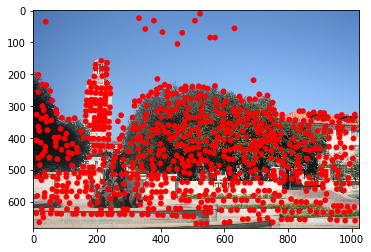

<Figure size 432x288 with 0 Axes>

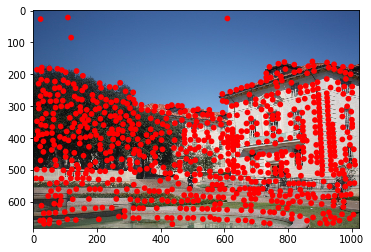

In [5]:
n = 2
sigma = 1.5*n
window_size = int(6*sigma)
if(window_size%2 == 0):
    window_size += 1
filtered_image1 = apply_filter(image1, differenceOfGaussian(n,window_size, sigma))
features_image1 = max_filter(image1, filtered_image1, direction1, window_size, sigma)
filtered_image2 = apply_filter(image2, differenceOfGaussian(n,window_size, sigma))
features_image2 = max_filter(image2, filtered_image2, direction2, window_size, sigma)

# Scoring descriptors
The score for each descriptor is stored which is the ratio of the Euclidean distances of the descriptor from the first best match to that of the second best match.

In [6]:
for i in features_image1:
    matches = sorted(features_image2, key = lambda x:x.distance(i))
    i.score = i.distance(matches[0])/i.distance(matches[1])

In [7]:
for i in features_image2:
    matches = sorted(features_image1, key = lambda x:x.distance(i))
    i.score = i.distance(matches[0])/i.distance(matches[1])

# Sorting out features based on their score
The features are sorted out according to their score

In [8]:
best_features1 = sorted(features_image1, key = lambda x:x.score)

In [9]:
best_features2 = sorted(features_image2, key = lambda x:x.score)

# Removing the descriptors whose score is above the threshold
The descriptors whose score is high are eliminated for better matches of features between two images

In [10]:
best1 = []
for i in best_features1:
    match = sorted(features_image2, key = lambda x:x.distance(i))[0]
    if(i.score < 0.8):
        best1.append([i.x, i.y, match.x, image1.shape[1]+match.y, 
                      i.distance(match)])
best1 = sorted(best1, key=lambda x:x[4])

In [11]:
best2 = []
for i in best_features2:
    match = sorted(features_image1, key = lambda x:x.distance(i))[0]
    if(i.score < 0.8):
        best2.append([match.x, match.y, i.x, image1.shape[1]+i.y, 
                      match.distance(i)])
best2 = sorted(best2, key=lambda x:x[4])

In [12]:
best1.extend(best2)
best = best1

# Plotting the best features obtained
The best features are then plotted against the images.

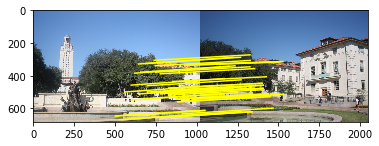

In [13]:
plt.figure()
transformed_coordinates = defaultdict(lambda:defaultdict(lambda:np.array([])))
plt.imshow(np.concatenate((image1, image2), axis = 1))
count = 0
transformed = set({})
for i in best:
    plt.plot([i[1], i[3]], [i[0], i[2]], c='yellow')
    transformed.add(((i[0], i[1]),(i[2], i[3])))
    transformed_coordinates[i[0]][i[1]] = np.array([i[2], i[3]])
    count += 1
plt.show()

# Performing RANSAC
RANSAC is performed over any four random points and the homography matrix and the corresponding error is calculated for each iteration. Atlast the homography matrix which gives the least error is taken into consideration for image stitching.


In [14]:
min_h_matrix = np.zeros((3, 3))
min_error = np.inf
for j in range(50000):
    count = 0
    already = set({})
    i = 0
    p_matrix = []
    while(i <= 3):
        i += 1
        rand_choice = random.choice(tuple(transformed))
        already.add(rand_choice)
        if(len(already)!=i):
            i -= 1
        else:
            p_matrix.extend([[-rand_choice[0][0], -rand_choice[0][1], 
                              -1, 0, 0, 0, rand_choice[0][0]*
                              rand_choice[1][0],
                              rand_choice[0][1]*rand_choice[1][0], 
                              rand_choice[1][0]],
                             [0, 0, 0, -rand_choice[0][0], -rand_choice[0][1], 
                              -1,
                              rand_choice[0][0]*rand_choice[1][1],
                              rand_choice[0][1]*rand_choice[1][1],
                              rand_choice[1][1]]])
    U, S, V = np.linalg.svd(p_matrix)
    p_matrix.append([0, 0, 0, 0, 0, 0, 0, 0, 1])
    h_matrix = (np.dot(np.linalg.inv(np.array(p_matrix)),
                       np.array([0, 0, 0, 0, 0, 0, 0, 0, 1]))).reshape(3, 3)
    error = 0
    for i in transformed:
        result = np.dot(h_matrix, np.array([i[0][0], i[0][1], 1]))
        error += np.linalg.norm(np.ceil(result/(result[-1]+
                    0.0000000000000000000000000001))-
                                np.array([i[1][0], i[1][1], 1]))
    if(error < min_error):
        min_h_matrix = h_matrix
        min_error = error
print("H matrix:", min_h_matrix)
print("Minimum error obtained:", min_error)

H matrix: [[ 1.19339026e+00  1.64028978e-01 -1.60511741e+02]
 [-6.85717515e-02  1.54705259e+00  4.59931268e+02]
 [ 8.60777543e-06  2.61957080e-04  1.00000000e+00]]
Minimum error obtained: 34.46011823444822


# Obtaining transformed points and checking for inliers
The features and their transformed points are plotted on the image and around 37 of 43 features have error less than 3.

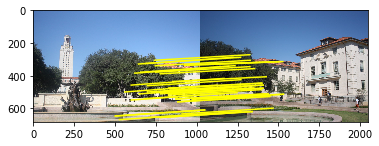

Number of inliers: 37
Total number of points: 43


In [15]:
plt.figure()
plt.imshow(np.concatenate((image1, image2), axis = 1))
inliers = 0
for i in best:
    result = np.dot(min_h_matrix, np.array([i[0], i[1], 1]))
    result = result//result[-1]
    plt.plot([i[1], result[1]], [i[0], result[0]], c='yellow')
    error = np.linalg.norm(np.array(transformed_coordinates[i[0]][i[1]])
                           -np.array([result[0], result[1]]))
    if(error <= 3):
        inliers += 1
plt.show()
print("Number of inliers:", inliers)
print("Total number of points:", len(best))

# Storing the transformed coordinates
The transformed coordinates along with their respective colors are stored.

In [16]:
pixels = []
colors = []
for i in np.arange(0, image1.shape[0], 0.5):
    for j in np.arange(0, image1.shape[1], 0.5):
        result = np.dot(min_h_matrix, np.array([i, j, 1]))
        result = result/result[-1]
        pixels.append(np.array([int(result[0]), int(result[1])]))
        colors.append(image1[int(i)][int(j)])
pixels = np.array(pixels)
colors = np.array(colors)

# Joining the images and then blending them
The images are then brought under a single image and the intersection part is blended using weighted average which gives better results.

In [17]:
max_x = np.max(pixels[:, 0])
min_x = np.min(pixels[:, 0])
max_y = np.max(pixels[:, 1])
min_y = np.min(pixels[:, 1])
min_value = defaultdict(lambda:np.inf)
max_value = defaultdict(lambda:-np.inf)
new_image = np.zeros((image1.shape[0]-min_x+1, 
                      image1.shape[1]+image2.shape[1]-min_y+1, 
                      3))
combined_points = []
for i in range(len(pixels)):
    if(new_image[pixels[i][0]-min_x, pixels[i][1]-min_y, 0] == 0
       and new_image[pixels[i][0]-min_x, pixels[i][1]-min_y, 1] == 0
       and new_image[pixels[i][0]-min_x, pixels[i][1]-min_y, 2] == 0):
        new_image[pixels[i][0]-min_x, pixels[i][1]-min_y, 0] = colors[i][0]
        new_image[pixels[i][0]-min_x, pixels[i][1]-min_y, 1] = colors[i][1]
        new_image[pixels[i][0]-min_x, pixels[i][1]-min_y, 2] = colors[i][2]
for i in range(image2.shape[0]):
    for j in range(image2.shape[1]):
        X = i - min_x
        Y = image1.shape[1]-min_y+j
        if(new_image[X][Y][0] != 0 or new_image[X][Y][1] != 0
           or new_image[X][Y][2] != 0):
            min_value[X] = min(min_value[X], Y)
            max_value[X] = max(max_value[X], Y)
for i in range(image2.shape[0]):
    for j in range(image2.shape[1]):
        X = i - min_x
        Y = image1.shape[1]-min_y+j
        if(new_image[X][Y][0] == 0 and new_image[X][Y][1] == 0
           and new_image[X][Y][2] == 0):
            new_image[X][Y] = image2[i][j]
        else: 
            new_image[X][Y] = np.ceil((new_image[X][Y]*(max_value[X]-Y)
                                       /(max_value[X]-min_value[X]))
                                      + (image2[i][j]*((Y-min_value[X])
                                    /(max_value[X]-min_value[X]))))

# Plotting the final image obtained
The final image is then cropped and displayed as follows.

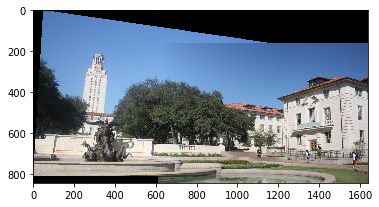

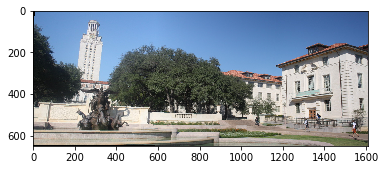

In [18]:
plt.figure()
new_image = new_image/np.max(new_image)
plt.imshow(new_image)
plt.show()
plt.figure()
plt.imshow(new_image[165:max_x+165,30:])
plt.show()